In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

In [72]:
'''
Here we will define functions which will allow us to analyse a given soil spectroscopy and what the spectral graph means in terms of chemical componentss/features like pH, Nitrogen content, etc.

Spectral readings -> features

'''




ossl_data = pd.read_csv(r"ossl_all_L0_v1.2.csv")
print(ossl_data.shape)

C:\Users\jagda\AppData\Local\Temp\ipykernel_12984\3375415800.py:11: DtypeWarning: Columns (1,4,5,6,15,16,17,21,25,62,111,112,113,114,115,116,117,118,119,120,121,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833) have mixed types. Specify dtype option on import or set low_memory=False.
  ossl_data = pd.read_csv(r"ossl_all_L0_v1.2.csv")


(135651, 2910)


In [73]:
sample_data = ossl_data.sample(n=1000, random_state=1)
print(sample_data.shape)

(1000, 2910)


In [74]:

numerical_ossl = sample_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_ossl.corr()


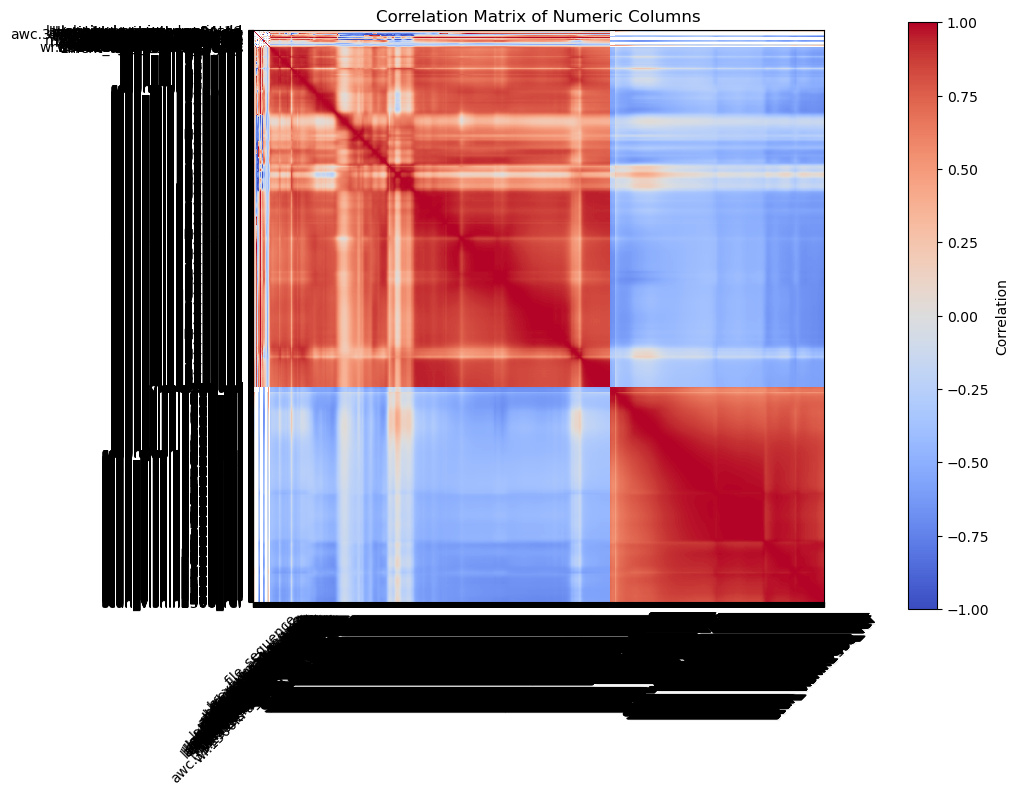

In [ ]:
'''fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

plt.imshow(corr_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Correlation Matrix of Numeric Columns")
plt.show()'''

In [76]:
visnir = ossl_data[[col for col in ossl_data.columns if "visnir" in col]]
print(visnir.shape)

notmir =  ossl_data[[col for col in ossl_data.columns if "mir" not in col]]
print(notmir)

(135651, 1087)
       dataset.code_ascii_txt id.layer_local_c  \
0                  AFSIS1.SSL        icr072246   
1                  AFSIS1.SSL        icr072247   
2                  AFSIS1.SSL        icr072266   
3                  AFSIS1.SSL        icr072267   
4                  AFSIS1.SSL        icr072286   
...                       ...              ...   
135646              LUCAS.SSL      2015.648817   
135647              LUCAS.SSL      2015.649017   
135648              LUCAS.SSL      2015.649017   
135649              LUCAS.SSL      2015.649617   
135650              LUCAS.SSL      2015.649817   

                       id.layer_uuid_txt  \
0       ded584d70bf0474202d30e575ae24784   
1       7c080e182bc23e19747629f46edbc6c4   
2       03bbd570dfd399bfd866ebcdf860de39   
3       887d316328ef950eeca33293bfe052bf   
4       ca03ce6e439b1909c5a4a771c0afa951   
...                                  ...   
135646  13b75cfc186ce496b308579a63521dad   
135647  ce7853e20ef27df1940eff8c

In [77]:
nulls = notmir.isnull().sum()

print(nulls)
print(notmir.shape) 

nonscanned = notmir[[col for col in notmir.columns if "scan" not in col]]
print(nonscanned.shape)

dataset.code_ascii_txt        0
id.layer_local_c              0
id.layer_uuid_txt             0
id.project_ascii_txt          0
id.location_olc_txt       47944
                          ...  
scan_visnir.2492_ref      71007
scan_visnir.2494_ref      71007
scan_visnir.2496_ref      71007
scan_visnir.2498_ref      71007
scan_visnir.2500_ref      71007
Length: 1198, dtype: int64
(135651, 1198)
(135651, 110)


In [78]:
'''print(nonscanned.columns)
nonscanned.head()
nulls_non = nonscanned.isnull().sum()   
print(nonscanned)'''
#dropping rows with null values in scan.visnir columns
cleaned_data = notmir.dropna(subset=visnir.columns, how='all').copy()
print(cleaned_data)

       dataset.code_ascii_txt id.layer_local_c  \
3817              ICRAF.ISRIC     FS15R_FS4068   
3818              ICRAF.ISRIC     FS15R_FS4069   
3819              ICRAF.ISRIC     FS15R_FS4070   
3820              ICRAF.ISRIC     FS15R_FS4071   
3821              ICRAF.ISRIC     FS15R_FS4072   
...                       ...              ...   
135646              LUCAS.SSL      2015.648817   
135647              LUCAS.SSL      2015.649017   
135648              LUCAS.SSL      2015.649017   
135649              LUCAS.SSL      2015.649617   
135650              LUCAS.SSL      2015.649817   

                       id.layer_uuid_txt  \
3817    594ef6c549138844cf79a0fece6de7d2   
3818    7417caf4328373c2f6b2977817f508b6   
3819    e01efc61d0222fc5ca44656483dfa665   
3820    5c1dcddd9cfe540857cc2bfea3d9a44b   
3821    393ab838badfeb6e12520f09c83e479b   
...                                  ...   
135646  13b75cfc186ce496b308579a63521dad   
135647  ce7853e20ef27df1940eff8c4082a822   
135

In [79]:


def safe_mean(df, cols):
    existing_cols = [col for col in cols if col in df.columns]
    if existing_cols:
        return df[existing_cols].mean(axis=1)
    else:
        return pd.Series([np.nan] * len(df), index=df.index)
    

'''
Features:
    ~Exchangeable Aluminium (al.ext_aquaregia_g.kg,
                            al.ext_usda.a1056_mg.kg,
                            al.ext_usda.a69_cmolc.kg)

    Bulk Density (bd_usda.a21_g.cm3,
                  bd_usda.a4_g.cm3)
'''
cleaned_data['p4.BD.g_cm3'] = safe_mean(cleaned_data, ['bd_usda.a21_g.cm3', 'bd_usda.a4_g.cm3'])
'''
    carbon weight % (c.tot_usda.a622_w.pct) #has caco3 influence
'''
cleaned_data['C_hard.wt_pct'] = cleaned_data['c.tot_usda.a622_w.pct']
'''
    Nutrient Contents: 
                        ~Ca:
                            (ca.ext_usda.a1059_mg.kg,
                            ca.ext_usda.a722_cmolc.kg)

                        ~Cu:
                            (cu.ext_usda.a1063_mg.kg)

                        Fe:
                            (fe.ext_usda.a1064_mg.kg, 
                            fe.ox_usda.a60_w.pct)
'''
cleaned_data["fe.ox_usda.a60_w.pct"] = cleaned_data["fe.ox_usda.a60_w.pct"] *10000 #converting from wt% to mg/kg
cleaned_data['p3.Fe.mg_kg'] = safe_mean(cleaned_data, ['fe.ext_usda.a1064_mg.kg', 'fe.ox_usda.a60_w.pct'])
'''
                        K: 
                            (k.ext_usda.a1065_mg.kg,
                              k.ext_usda.a725_cmolc.kg)*,

'''
cleaned_data['k.ext_usda.a725_cmolc.kg'] = cleaned_data['k.ext_usda.a725_cmolc.kg'] * 391.3 #converting from cmolc/kg to mg/kg
cleaned_data['p3.K.mg_kg'] = safe_mean(cleaned_data, ['k.ext_usda.a1065_mg.kg', 'k.ext_usda.a725_cmolc.kg'])
'''
                        ~Mg: 
                            (mg.ext_usda.a1066_mg.kg,
                              mg.ext_usda.a724_cmolc.kg)*,
                        ~Mn:
                            (mn.ext_usda.a1067_mg.kg,
                            mn.ext_usda.a70_mg.kg)
                        N:
                            (n.tot_iso.11261_w.pct, *
                            n.tot_usda.a623_w.pct) ***

'''
cleaned_data['p2.N.wt_pct'] = safe_mean(cleaned_data, ['n.tot_iso.11261_w.pct', 'n.tot_usda.a623_w.pct'])
'''
                        ~Na:
                            (na.ext_usda.a726_cmolc.kg)
                        P:
                            (p.ext_iso.11263_mg.kg, 
                            p.ext_usda.a1070_mg.kg,
                            p.ext_usda.a274_mg.kg) *
'''
cleaned_data['p3.P.mg_kg'] = safe_mean(cleaned_data, ['p.ext_iso.11263_mg.kg', 'p.ext_usda.a1070_mg.kg', 'p.ext_usda.a274_mg.kg'])
'''
                        S:
                            s.tot_usda.a624_w.pct
'''
cleaned_data['p3.S.wt_pct'] = cleaned_data['s.tot_usda.a624_w.pct']
'''
                        Zn:
                            zn.ext_usda.a1073_mg.kg
'''
cleaned_data['p2.Zn.mg_kg'] = cleaned_data['zn.ext_usda.a1073_mg.kg']
'''
    Organic Carbon:
                (oc_iso.10694_w.pct, *
                oc_usda.c1059_w.pct, 
                oc_usda.c729_w.pct)*

'''
cleaned_data['p2.OC.wt_pct'] = safe_mean(cleaned_data, ['oc_iso.10694_w.pct', 'oc_usda.c1059_w.pct', 'oc_usda.c729_w.pct'])
'''
    pH: 
        ph.cacl2_iso.10390_index *
        ph.cacl2_usda.a477_index
        ph.cacl2_usda.a481_index
        ph.h2o_iso.10390_index
        ph.h2o_usda.a268_index
'''
cleaned_data['p1.pH.index'] = safe_mean(cleaned_data, ['ph.cacl2_iso.10390_index', 'ph.cacl2_usda.a477_index',
                                            'ph.cacl2_usda.a481_index', 'ph.h2o_iso.10390_index',
                                            'ph.h2o_usda.a268_index'])
'''
    Electrical Conductivity (ec_iso.11265_ds.m,
                            ec_usda.a364_ds.m)
'''
cleaned_data['p1.EC.ds_m'] = safe_mean(cleaned_data, ['ec_iso.11265_ds.m', 'ec_usda.a364_ds.m'])
'''

    ~Carbonate Content (caco3_iso.10693_w.pct,
                        caco3_usda.a54_w.pct)

    Cation Exchange Capacity (cec_iso.11260_cmolc.kg,
                            cec_usda.a723_cmolc.kg)

'''
cleaned_data['p4.CEC.cmolc_kg'] = safe_mean(cleaned_data, ['cec_iso.11260_cmolc.kg', 'cec_usda.a723_cmolc.kg'])
'''
    Coarse Fragments (cf_iso.11464_w.pct,
                        cf_usda.c236_w.pct)
'''
cleaned_data['p4.CF.wt_pct'] = safe_mean(cleaned_data, ['cf_iso.11464_w.pct', 'cf_usda.c236_w.pct'])
'''
    Clay Content (clay_iso.11277_w.pct,
                    clay.tot_usda.a334_w.pct)

'''
cleaned_data['p1.Clay.wt_pct'] = safe_mean(cleaned_data, ['clay_iso.11277_w.pct', 'clay.tot_usda.a334_w.pct'])
'''
    Sand Content:
                sand.tot_iso.11277_w.pct
                sand.tot_usda.c405_w.pct
                sand.tot_usda.c60_w.pct *
                silt.tot_iso.11277_w.pct *
'''
cleaned_data['p1.Sand.wt_pct'] = safe_mean(cleaned_data, ['sand.tot_iso.11277_w.pct',  'sand.tot_usda.c405_w.pct',
                                               'sand.tot_usda.c60_w.pct',
                                               'silt.tot_iso.11277_w.pct'])
'''
    Silt Content:
                silt.tot_usda.c407_w.pct
                silt.tot_usda.c62_w.pct *
'''
cleaned_data['p1.Silt.wt_pct'] = safe_mean(cleaned_data, ['silt.tot_usda.c407_w.pct', 'silt.tot_usda.c62_w.pct'])
'''

    Water Retention:
                wr.10kPa_usda.a414_w.pct
                wr.10kPa_usda.a8_w.pct
                wr.1500kPa_usda.a417_w.pct
                wr.33kPa_usda.a415_w.pct
                wr.33kPa_usda.a9_w.pct
'''

#unique datasets in cleaned_data
unique_datasets = cleaned_data["dataset.code_ascii_txt"].unique()
print(unique_datasets)
print(cleaned_data.shape)


['ICRAF.ISRIC' 'KSSL.SSL' 'LUCAS.WOODWELL.SSL' 'LUCAS.SSL']
(64644, 1214)


In [80]:
p1_cols = cleaned_data.columns[cleaned_data.columns.str.startswith("p1")]
p2_cols = cleaned_data.columns[cleaned_data.columns.str.startswith("p2")]
p3_cols = cleaned_data.columns[cleaned_data.columns.str.startswith("p3")]
p4_cols = cleaned_data.columns[cleaned_data.columns.str.startswith("p4")]
print(p1_cols)

feature_cols = p1_cols.tolist() + p2_cols.tolist() + p3_cols.tolist() + p4_cols.tolist()

p1_nulls = cleaned_data[p1_cols].isna().all(axis=1).sum()
p1_nulls_any = cleaned_data[p1_cols].isna().any(axis=1).sum()
p2_nulls = cleaned_data[p2_cols].isna().all(axis=1).sum()
p1andp2_nulls = cleaned_data[p1_cols.tolist() + p2_cols.tolist()].isna().all(axis=1).sum()
p3_nulls = cleaned_data[p3_cols].isna().all(axis=1).sum()
p4_nulls = cleaned_data[p4_cols].isna().all(axis=1).sum()
print(f"Rows with all p1 features missing: {p1_nulls}")
print(f"Rows with all p2 features missing: {p2_nulls}") 
print(f"Rows with all p3 features missing: {p3_nulls}")
print(f"Rows with all p4 features missing: {p4_nulls}")
print(f"Rows with all p1 and p2 features missing: {p1andp2_nulls}")
print(cleaned_data[feature_cols].isna().sum(), "\n\n\n")
print(cleaned_data[feature_cols].shape)
print(p1_nulls_any)




Index(['p1.pH.index', 'p1.EC.ds_m', 'p1.Clay.wt_pct', 'p1.Sand.wt_pct',
       'p1.Silt.wt_pct'],
      dtype='object')
Rows with all p1 features missing: 19908
Rows with all p2 features missing: 373
Rows with all p3 features missing: 399
Rows with all p4 features missing: 17971
Rows with all p1 and p2 features missing: 261
p1.pH.index        20054
p1.EC.ds_m         42811
p1.Clay.wt_pct     60738
p1.Sand.wt_pct     37558
p1.Silt.wt_pct     60744
p2.N.wt_pct         4074
p2.Zn.mg_kg        64644
p2.OC.wt_pct         433
p3.Fe.mg_kg        64644
p3.K.mg_kg         20155
p3.P.mg_kg         23880
p3.S.wt_pct        44837
p4.BD.g_cm3        43893
p4.CEC.cmolc_kg    41957
p4.CF.wt_pct       41407
dtype: int64 



(64644, 15)
64595


In [81]:
#dropping all rows where all p1 columns are null
priority_data = cleaned_data.dropna(subset=p1_cols, how='all')
print(priority_data.shape)

(44736, 1214)


In [82]:
#now to interpolate spectral values to our sensor's wavelengths
sensor_wavelengths = np.array([410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940])
print((sensor_wavelengths))

[410 435 460 485 510 535 560 585 610 645 680 705 730 760 810 860 900 940]


In [83]:
#Selecting Sensor data columns
sensor_cols = [col for col in cleaned_data.columns if "scan_visnir." in col] #the visnir data cols
sensor_cut_cols = [col for col in sensor_cols if int(col.split('_')[1].split('.')[1]) >= 350 and int(col.split('_')[1].split('.')[1]) <= 990]
#sensor_cut_cols is the visnir data cols from 350 to 990 nm

#nulls are there till 398nm (40.7k rows)
print(sensor_cols) 

sensor_train_data = priority_data[sensor_cut_cols]
print(sensor_train_data.shape)
print(sensor_train_data.isna().sum())
#interpolating each row to fill missing values (linear interpolation)
sensor_train_data = sensor_train_data.interpolate(method='linear', axis=1, limit_direction='both')
print(sensor_train_data.shape)

['scan_visnir.350_ref', 'scan_visnir.352_ref', 'scan_visnir.354_ref', 'scan_visnir.356_ref', 'scan_visnir.358_ref', 'scan_visnir.360_ref', 'scan_visnir.362_ref', 'scan_visnir.364_ref', 'scan_visnir.366_ref', 'scan_visnir.368_ref', 'scan_visnir.370_ref', 'scan_visnir.372_ref', 'scan_visnir.374_ref', 'scan_visnir.376_ref', 'scan_visnir.378_ref', 'scan_visnir.380_ref', 'scan_visnir.382_ref', 'scan_visnir.384_ref', 'scan_visnir.386_ref', 'scan_visnir.388_ref', 'scan_visnir.390_ref', 'scan_visnir.392_ref', 'scan_visnir.394_ref', 'scan_visnir.396_ref', 'scan_visnir.398_ref', 'scan_visnir.400_ref', 'scan_visnir.402_ref', 'scan_visnir.404_ref', 'scan_visnir.406_ref', 'scan_visnir.408_ref', 'scan_visnir.410_ref', 'scan_visnir.412_ref', 'scan_visnir.414_ref', 'scan_visnir.416_ref', 'scan_visnir.418_ref', 'scan_visnir.420_ref', 'scan_visnir.422_ref', 'scan_visnir.424_ref', 'scan_visnir.426_ref', 'scan_visnir.428_ref', 'scan_visnir.430_ref', 'scan_visnir.432_ref', 'scan_visnir.434_ref', 'scan_visn

In [84]:
#resampling function
high_res_wavelengths = np.array([int(col.split('_')[1].split('.')[1]) for col in sensor_cut_cols])
#sensor_wavelengths = np.array([410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940])   
def resample_to_master(high_res_y):
    # Dynamic FWHM: 
    #Since gaps vary, we can set a fixed FWHM or calculate based on sensor specs.
    fwhm = 20.0  # Fixed FWHM for simplicity; can be adjusted based on sensor specs.
    
    # 1. Gaussian Blur (Simulate Sensor Optics)
    step_size = high_res_wavelengths[1] - high_res_wavelengths[0]

    #apply Gaussian kernel smoothing sigma = FWHM/2(sqrt(2 * ln(2)))
    #Reference: https://mathworld.wolfram.com/GaussianFunction.html
      
    sigma = (fwhm / 2.355) / step_size
    smoothed_y = gaussian_filter1d(high_res_y, sigma)
    
    # 2. Interpolate to the Sorted Master List
    interpolator = interp1d(high_res_wavelengths, smoothed_y, kind='cubic', fill_value="extrapolate")
    return interpolator(sensor_wavelengths)

In [85]:
print("\nStarting Conversion of 40,000 samples...")
X_input = sensor_train_data.values
final_data = []

# Iterate through every row
for i in range(len(X_input)):
    # Extract the single spectrum
    raw_row = X_input[i]
    
    # Transform it
    sensor_row = resample_to_master(raw_row)
    
    # Store it
    final_data.append(sensor_row)
    
    # Progress Bar
    if i % 5000 == 0:
        print(f"Processed {i} / {len(X_input)} rows...")
# ==========================================
# Create a new clean DataFrame
df_final = pd.DataFrame(final_data, columns=[str(w) for w in sensor_wavelengths])
print("Conversion Complete!")


Starting Conversion of 40,000 samples...
Processed 0 / 44736 rows...
Processed 5000 / 44736 rows...
Processed 10000 / 44736 rows...
Processed 15000 / 44736 rows...
Processed 20000 / 44736 rows...
Processed 25000 / 44736 rows...
Processed 30000 / 44736 rows...
Processed 35000 / 44736 rows...
Processed 40000 / 44736 rows...
Conversion Complete!


In [86]:
print(feature_cols)
print(df_final.shape)
print(priority_data[feature_cols].shape)
for col in feature_cols:
   df_final[col] = priority_data[col].values



['p1.pH.index', 'p1.EC.ds_m', 'p1.Clay.wt_pct', 'p1.Sand.wt_pct', 'p1.Silt.wt_pct', 'p2.N.wt_pct', 'p2.Zn.mg_kg', 'p2.OC.wt_pct', 'p3.Fe.mg_kg', 'p3.K.mg_kg', 'p3.P.mg_kg', 'p3.S.wt_pct', 'p4.BD.g_cm3', 'p4.CEC.cmolc_kg', 'p4.CF.wt_pct']
(44736, 18)
(44736, 15)


In [87]:
#Saving final data
df_final.to_csv("spectral_feature_data.csv", index=False)

print("Saved spectral_feature_data.csv")
print(df_final.head())
print(df_final.shape)

Saved spectral_feature_data.csv
        410       435       460       485       510       535       560  \
0  0.109455  0.124974  0.138140  0.147410  0.163931  0.183021  0.201815   
1  0.118423  0.139766  0.158809  0.171252  0.198595  0.233667  0.270472   
2  0.119001  0.140494  0.159749  0.172125  0.199565  0.236209  0.278400   
3  0.067740  0.075554  0.084986  0.091525  0.105907  0.128666  0.181330   
4  0.082394  0.092627  0.106960  0.117630  0.135810  0.164586  0.221797   

        585       610       645  ...  p2.N.wt_pct  p2.Zn.mg_kg  p2.OC.wt_pct  \
0  0.217923  0.230336  0.253126  ...          NaN          NaN          0.95   
1  0.301649  0.321070  0.364047  ...          NaN          NaN          0.42   
2  0.316585  0.339447  0.385621  ...          NaN          NaN          0.38   
3  0.269774  0.344423  0.403455  ...          NaN          NaN          0.27   
4  0.302863  0.361396  0.421302  ...          NaN          NaN          0.34   

   p3.Fe.mg_kg  p3.K.mg_kg  p3.P.mg_